# 3.1 確定的レベルと確定的傾き

英国ドライバーの死傷者数の分析を行う。

In [1]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd

# scipyの統計パッケージも使います。
from scipy import stats

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa

# 描画のためのライブラリです。
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ブラウザ内に画像を埋め込むための命令です
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

In [101]:
def ShowDiagnostics(res, nMaxLag):
    # Purpose: Show diagnostics table
    # Args:        res:    Result of statsmodels
    #          nMaxLag:    max lag for BoxLjung
    
    ## Get statistics
    # Indipendence check
    Q  = res.test_serial_correlation('ljungbox',nMaxLag)
    Q  = Q[0,0][nMaxLag-1]
    Qc = stats.chi2.ppf(0.95,nMaxLag-len(res.params)+1)
    # Heteroskewdasticity check
    tmp = res.filtered_state.shape # Number of state variables
    n   = tmp[1]
    d   = tmp[0]
    nBlockSize = round((n-d)/3)
    H   = res.test_heteroskedasticity('breakvar')
    H   = H[0,0]
    hflag = 0
    if H < 1:
        H = 1/H
        hflag = 1

    Hc  = stats.f.ppf(0.975,nBlockSize,nBlockSize)
    # Normality check
    N  = res.test_normality('jarquebera')
    N  = N[0,0]
    Nc = stats.chi2.ppf(0.95,2)
    
    value     = np.array([Q,H,N])
    critical  = np.array([Qc,Hc,Nc])
    condition = (value <= critical)
    satisfied = np.where(condition, '+', '-')

    Hstr      = np.where(hflag, '1/H({})'.format(nBlockSize), 'H({})'.format(nBlockSize))

    dfDiag = pd.DataFrame({
        '1. Stat':      ['Q({})'.format(nMaxLag), Hstr, 'N'],
        '2. Value':     value,
        '3. Critical':  critical,
        '4. Satisfied': satisfied},
        index = ['Independence','Homoscedasticity','Normality'])
    
    # Standalized resid
    stdError = res.filter_results.standardized_forecasts_error
    rc  = 2/np.sqrt(n)
    fig = tsa.plot_acf(stdError[0],lags=nMaxLag,alpha=None)
    plt.fill_between(np.arange(1,nMaxLag+1,1),-rc,rc,alpha=0.2)
    
    # Calculate AIC
    AIC = (1/n)*(-2*res.llf+2*(d + len(res.params)))
    print('AIC='+str(AIC))
    
    return dfDiag

In [8]:
#データの読み込み
df = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None)
#インデックスを以下のように設定 (MSは月毎の意味)
df.index = pd.date_range('1969-JAN', '1984-DEC', freq='MS')
#コラム名を変更
df.columns = ['KSI']
#対数KSIを計算してコラムに追加
df['logKSI'] = np.log(df['KSI'])

In [9]:
df.head()

,KSI,logKSI
1969-01-01,1687,7.430707
1969-02-01,1508,7.318540
1969-03-01,1507,7.317876
1969-04-01,1385,7.233455
1969-05-01,1632,7.397562


# 確定的レベルと確定的傾き

In [29]:
#http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

KSI_dtmodel = sm.tsa.UnobservedComponents(df['logKSI'], 'deterministic trend')
KSI_dtresults = KSI_dtmodel.fit()
print(KSI_dtresults.summary())

                         Unobserved Components Results                         
Dep. Variable:                  logKSI   No. Observations:                  192
Model:             deterministic trend   Log Likelihood                  79.502
Date:                 Mon, 08 May 2017   AIC                           -157.004
Time:                         22:49:48   BIC                           -153.746
Sample:                     01-01-1969   HQIC                          -155.685
                          - 12-01-1984                                         
Covariance Type:                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0230      0.003      8.826      0.000       0.018       0.028
Ljung-Box (Q):                      645.74   Jarque-Bera (JB):                 1.79
Prob(Q):             

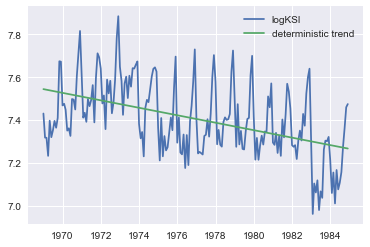

In [30]:
# 確定的トレンドのプロット (この図は図1.1に等しい)
df['deterministic trend'] = KSI_dtresults.smoothed_state[0]
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.plot(df.index,df['deterministic trend'],label='deterministic trend')
plt.legend()

AIC=-0.796895673548


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q15,305.681770,24.995790,-
Homoscedasticity,H63,1.359898,1.646022,+
Normality,N,1.789846,5.991465,+


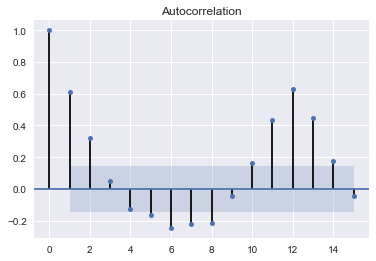

In [32]:
ShowDiagnostics(KSI_dtresults,15)

このモデルは確定的線形トレンドモデルの結果よりも良い(AIC=-0.638686)。しかし、残差の独立性が保たれていないことがわかる。また、確率的レベルモデルよりも当てはまりが悪い(AIC=-1.25914)

# 確率的レベルと確率的傾き

In [33]:
KSI_lltmodel = sm.tsa.UnobservedComponents(df['logKSI'], 'local linear trend')
KSI_lltresults = KSI_lltmodel.fit()
print(KSI_lltresults.summary())

                        Unobserved Components Results                         
Dep. Variable:                 logKSI   No. Observations:                  192
Model:             local linear trend   Log Likelihood                 119.960
Date:                Mon, 08 May 2017   AIC                           -233.921
Time:                        22:57:17   BIC                           -224.148
Sample:                    01-01-1969   HQIC                          -229.963
                         - 12-01-1984                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0021      0.001      1.773      0.076      -0.000       0.004
sigma2.level         0.0121      0.002      5.064      0.000       0.007       0.017
sigma2.trend      2.287e-11 

In [35]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
df['stochastic level and slope'] = KSI_lltresults.smoothed_state[0]
df['irregular'] = df['logKSI']-df['stochastic level and slope']

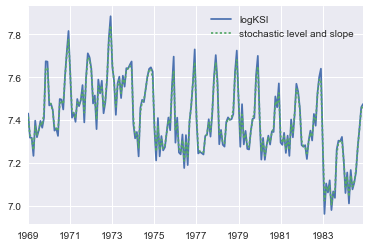

In [40]:
#図3.1
fig, ax = plt.subplots(1,1)
df.plot(y='logKSI',ax=ax)
df.plot(y='stochastic level and slope', style=':', ax=ax)

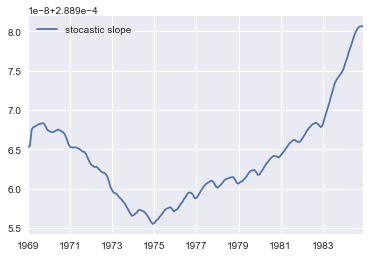

In [52]:
#図3.2
df['stocastic slope'] = KSI_lltresults.smoother_results.smoothed_state[1]
df.plot(y='stocastic slope')

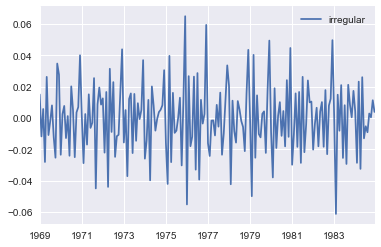

In [53]:
#図3.3
df.plot(y='irregular')

AIC=-1.19750365559


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q15,100.613230,22.362032,-
Homoscedasticity,H63,1.057830,1.646022,+
Normality,N,14.945754,5.991465,-


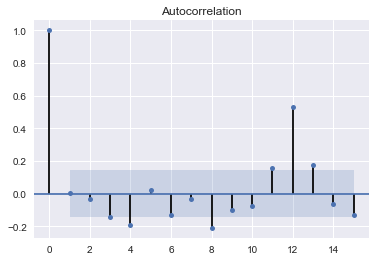

In [55]:
ShowDiagnostics(KSI_lltresults,15)

# 3.3 確率的レベルと確定的傾き

In [56]:
KSI_lldtmodel = sm.tsa.UnobservedComponents(df['logKSI'], 'local linear deterministic trend')
KSI_lldtresults = KSI_lldtmodel.fit()
print(KSI_lldtresults.summary())

                               Unobserved Components Results                                
Dep. Variable:                               logKSI   No. Observations:                  192
Model:             local linear deterministic trend   Log Likelihood                 119.960
Date:                              Mon, 08 May 2017   AIC                           -235.921
Time:                                      23:12:24   BIC                           -229.406
Sample:                                  01-01-1969   HQIC                          -233.282
                                       - 12-01-1984                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0021      0.001      2.044      0.041    8.72e-05       0.004
s

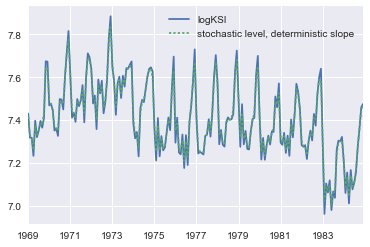

In [60]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
df['stochastic level, deterministic slope'] = KSI_lldtresults.smoothed_state[0]

#図3.4
fig, ax = plt.subplots(1,1)
df.plot(y='logKSI',ax=ax)
df.plot(y='stochastic level, deterministic slope',style=':',ax=ax)

AIC=-1.20792037843


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q15,100.614959,23.684791,-
Homoscedasticity,H63,1.057831,1.646022,+
Normality,N,14.945858,5.991465,-


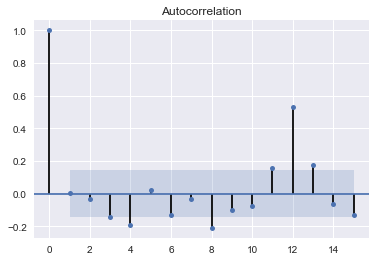

In [61]:
ShowDiagnostics(KSI_lldtresults,15)

# 3.4 ローカル線形トレンドモデルとフィンランドの事故

In [63]:
#データの読み込み
dfFin = pd.read_table('Norwayfinland.txt', skiprows=1, header=None)
dfFin.columns = ['year','Norway','Finland']
dfFin['logNorway']  = np.log(dfFin['Norway'])
dfFin['logFinland'] = np.log(dfFin['Finland'])
dfFin.index = pd.date_range('1970', '2003', freq='AS')

In [65]:
FIN_lltmodel = sm.tsa.UnobservedComponents(dfFin['logFinland'], 'local linear trend')
FIN_lltresults = FIN_lltmodel.fit()
print(FIN_lltresults.summary())

                        Unobserved Components Results                         
Dep. Variable:             logFinland   No. Observations:                   34
Model:             local linear trend   Log Likelihood                  26.740
Date:                Mon, 08 May 2017   AIC                            -47.480
Time:                        23:18:49   BIC                            -42.901
Sample:                    01-01-1970   HQIC                           -45.919
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0032      0.003      0.984      0.325      -0.003       0.010
sigma2.level       1.55e-07      0.006   2.41e-05      1.000      -0.013       0.013
sigma2.trend         0.0015 

In [67]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
dfFin['stochastic level and slope'] = FIN_lltresults.smoothed_state[0]
dfFin['irregular'] = dfFin['logFinland']-dfFin['stochastic level and slope']
dfFin['stocastic slope'] = FIN_lltresults.smoother_results.smoothed_state[1]

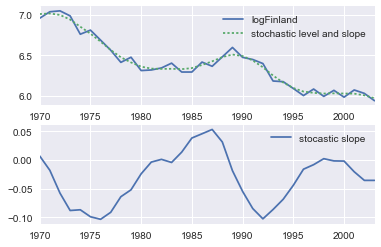

In [81]:
#図3.5
fig, ax = plt.subplots(2,1)
dfFin.plot(y='logFinland',ax=ax[0])
dfFin.plot(y='stochastic level and slope', style=':', ax=ax[0])
dfFin.plot(y='stocastic slope',ax=ax[1])

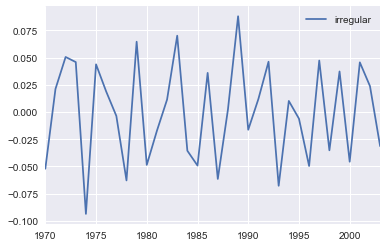

In [103]:
#図3.6
dfFin.plot(y='irregular')

AIC=-1.27883126548


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(10),7.044678,15.507313,+
Homoscedasticity,1/H(11),1.347831,3.473699,+
Normality,N,0.643979,5.991465,+


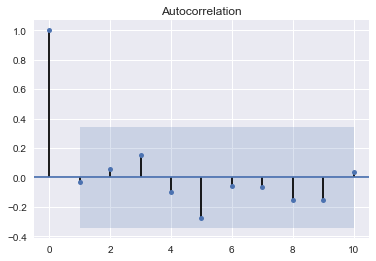

In [104]:
ShowDiagnostics(FIN_lltresults,10)

### 確定的レベルと確率的傾き

In [105]:
FIN_stmodel = sm.tsa.UnobservedComponents(dfFin['logFinland'], 'smooth trend')
FIN_stresults = FIN_stmodel.fit()
print(FIN_stresults.summary())

                        Unobserved Components Results                         
Dep. Variable:             logFinland   No. Observations:                   34
Model:                   smooth trend   Log Likelihood                  26.740
Date:                Mon, 08 May 2017   AIC                            -49.480
Time:                        23:50:09   BIC                            -46.428
Sample:                    01-01-1970   HQIC                           -48.439
                         - 01-01-2003                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0032      0.001      2.365      0.018       0.001       0.006
sigma2.trend         0.0015      0.001      1.688      0.091      -0.000       0.003
Ljung-Box (Q):              

In [106]:
# 予測結果をコラムに追加
# Stochastic levelはスムーシングされた結果
dfFin['deterministic level, stocastic slope'] = FIN_stresults.smoothed_state[0]
dfFin['irregular_st'] = dfFin['logFinland']-dfFin['deterministic level, stocastic slope']
dfFin['stocastic slope_st'] = FIN_stresults.smoother_results.smoothed_state[1]

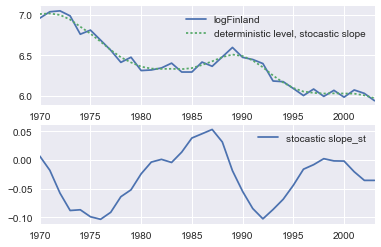

In [107]:
#図3.5a
fig, ax = plt.subplots(2,1)
dfFin.plot(y='logFinland',ax=ax[0])
dfFin.plot(y='deterministic level, stocastic slope', style=':', ax=ax[0])
dfFin.plot(y='stocastic slope_st',ax=ax[1])

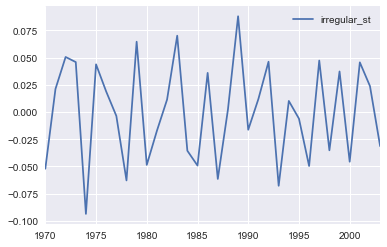

In [108]:
#図3.6a
dfFin.plot(y='irregular_st')

AIC=-1.3376549974


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(10),7.044588,16.918978,+
Homoscedasticity,1/H(11),1.347835,3.473699,+
Normality,N,0.643982,5.991465,+


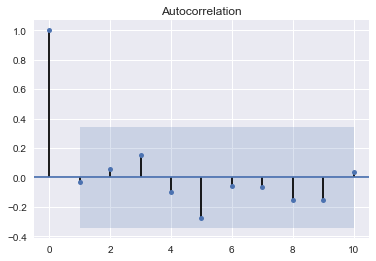

In [110]:
ShowDiagnostics(FIN_stresults,10)